In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.keras as tfk
import numpy as np

tfd = tfp.distributions
tfb = tfp.bijectors
tfkl = tfk.layers

import sys

sys.path.append("../")

In [2]:
from models.flows import Flow, MAF, CondMAF

# class CondMAF(Flow):
#     """Masked Autoregressive Flow model.
    
#     Based a chain of trainable 'Bijector' objects from the 
#     'tensorflow-probability' module
#     """
#     def __init__(self, n_dims, n_layers, units, name=None, dtype='float32'):
#         """Creates a MAF object.

#         Args:
#           n_dims: The dimensionality of input (and output) data
#           n_layers: The number of 'AutoregressiveNetwork' bijectors
#           units: The units of every 'AutoregressiveNetwork' object
#           name: String argument passed to the 'Model' parent class constructor
#           dtype: The type of data used by the network
#         """ 
#         super(CondMAF, self).__init__(name=name, dtype=dtype)

#         # Create the necessary 'AutoregressiveNetwork' bijectors
#         self.mades = [tfb.AutoregressiveNetwork(
#                             params=2, 
#                             hidden_units=units,
#                             input_order=self._input_order(i, n_layers),
#                             activation='tanh',
#                             event_shape=(n_dims,),
#                             conditional=True,
#                             conditional_event_shape=(1,))
#                      for i 
#                      in range(n_layers)]

#         """ Make a chain of MAF bijectors passing the previously defined
#         MADEs as the 'shift_and_log_scale_fn' """
#         self.bijectors = [tfb.MaskedAutoregressiveFlow(made, name=f'made{i}')
#                           for i, made 
#                           in enumerate(self.mades)]
#         self.chain = tfb.Chain(self.bijectors)
#         self.made_names = [f'made{i}' for i in range(n_layers)]

#         """Use bijector chain to make a TransformedDistribution starting 
#         from a Normal base distribution.""" 
#         self.distribution = tfd.TransformedDistribution(
#                 distribution=tfd.Sample(tfd.Normal(loc=0., scale=1.),
#                                         sample_shape=[n_dims]),
#                 bijector=self.chain)

#     def call(self, x):
#         """Returns the log likelihood of the input samples"""
#         x_ = x[0]
#         c_ = x[1]
#         kwargs = {key:{'conditional_input': c_}
#                   for key 
#                   in self.made_names}
#         return self.distribution.log_prob(x_, bijector_kwargs=kwargs)

#     def forward(self, x):
#         """Returns the input transformed by the forward bijector chain."""
#         x_ = x[0]
#         c_ = x[1].reshape(-1,1)
#         kwargs = {key:{'conditional_input': c_}
#                   for key 
#                   in self.made_names}
#         return self.chain(x_, **kwargs).numpy()

#     def inverse(self, y):
#         """Returns the input transformed by the inverse bijector chain."""
#         y_ = y[0]
#         c_ = y[1].reshape(-1,1)
#         kwargs = {key:{'conditional_input': c_}
#                   for key 
#                   in self.made_names}
#         return self.chain.inverse(y_, **kwargs).numpy()

#     def sample(self, c, sample_shape=()):
#         """Returns a sample from the transformed distribution"""
#         kwargs = {key:{'conditional_input': c.reshape(-1,1)}
#                   for key 
#                   in self.made_names}
#         return self.distribution.sample(sample_shape, 
#                                         bijector_kwargs=kwargs).numpy()

#     def forward_log_det_jacobian(self, x, event_ndims=1):
#         """Log of the Jacobian determinant for a forwad transofrmation."""
#         x_ = x[0]
#         c_ = x[1].reshape(-1,1)
#         kwargs = {key:{'conditional_input': c_}
#                   for key 
#                   in self.made_names}
#         return self.chain.forward_log_det_jacobian(x_, event_ndims=1,
#                                             **kwargs).numpy()

#     def inverse_log_det_jacobian(self, x, event_ndims=1):
#         """Log of the Jacobian determinant for an inverse transofrmation."""
#         x_ = x[0]
#         c_ = x[1].reshape(-1,1)
#         kwargs = {key:{'conditional_input': c_}
#                   for key 
#                   in self.made_names}
#         return self.chain.inverse_log_det_jacobian(x_, event_ndims=1,
#                                             **kwargs).numpy()

#     def _input_order(self, i, n_layers):
#         """Determine input order of a Layer given its index number"""
#         order = 'random'
#         if i == 0:
#             order = 'left-to-right'
#         elif i == n_layers-1:
#             order = 'right-to-left'
#         return order

In [3]:
from tensorflow.python.client import device_lib

devices = tf.config.list_physical_devices()
print("tensorflow", tf.__version__)
print("tensorflow-probability", tfp.__version__)
print("Available devices:", *[dev[1] for dev in devices])

# SEED = 42
# np.random.seed(SEED) 
# tf.random.set_seed(SEED)

tensorflow 2.4.1
tensorflow-probability 0.12.1
Available devices: CPU


### Load Data

In [4]:
from utils import load_json, dump_json

from loaders.LHCO import LhcoRnDLoader

loader = LhcoRnDLoader.from_json("../configs/loader/default_rnd.json")
dataset_cfg = load_json("../configs/loader/default_dataset.json")
dataset = loader.make_full_dataset(**dataset_cfg)

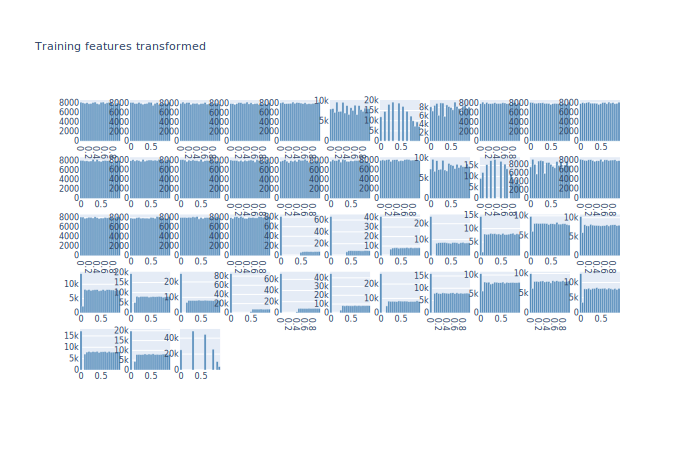

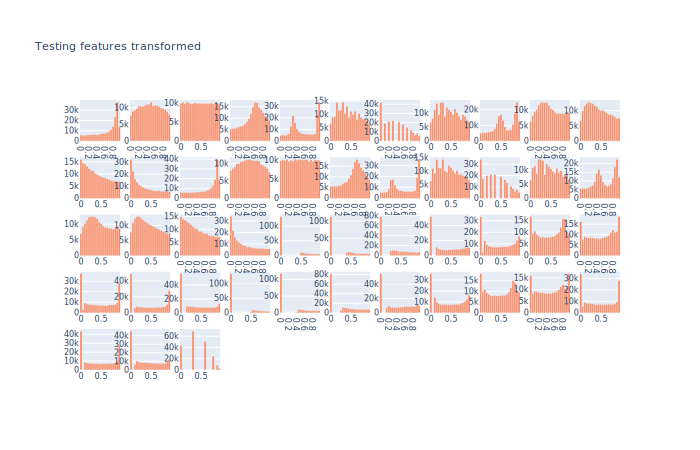

In [5]:
from plotting import feature_plots

fig = feature_plots(dataset['x_train'], 'all')
fig.update_layout(title="Training features transformed")
fig.show('svg')
fig = feature_plots(dataset['x_test'], 'all', color='coral')
fig.update_layout(title="Testing features transformed")
fig.show('svg')

### Density estimation

In [6]:
from density import GMM, ConvKDE

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "presentation"
from plotly.subplots import make_subplots

gmm=GMM(n_components=200, covariance_type='full')
gmm.fit(dataset["mjj_train"])
y_gmm = gmm.evaluate(dataset["mjj_train"])

fftkde = ConvKDE()
fftkde.fit(dataset["mjj_train"])#, range=(1500, 8000)) 
y_kde = fftkde.evaluate(dataset["mjj_train"])

w_gmm = gmm.get_weights(dataset['mjj_train'])
w_kde = fftkde.get_weights(dataset['mjj_train'])

w_kde_valid = fftkde.get_weights(dataset["mjj_valid"])
w_gmm_valid = gmm.get_weights(dataset["mjj_valid"])

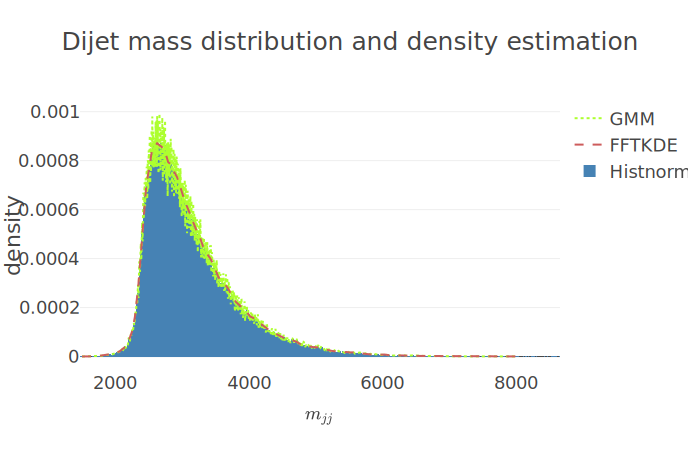

In [7]:
x_ref = np.linspace(1500, 8000, 1701)
y_gmm = gmm.evaluate(x_ref)
y_kde = fftkde.evaluate(x_ref)

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_ref, y=y_gmm, mode='lines', name='GMM',
                         line={'color': 'greenyellow', 'width': 2, 'dash': 'dot'}))
fig.add_trace(go.Scatter(x=x_ref, y=y_kde, mode='lines', name='FFTKDE',
                         line={'color': 'indianred', 'width': 2, 'dash': 'dash'}))
fig.add_trace(go.Histogram(x=dataset["mjj_train"], nbinsx=600, histnorm='probability density', 
                           marker_color='steelblue', name='Histnorm'))
fig.update_layout(
    title_text='Dijet mass distribution and density estimation',
    xaxis_title_text=r'$$m_{jj}$$',
    yaxis_title_text=r'density',
)
fig.show('svg')

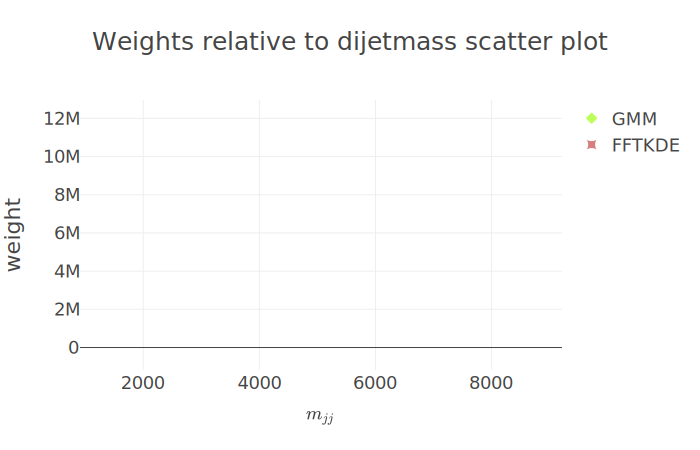

In [8]:
data_key = 'mjj_train'
w_gmm = gmm.get_weights(dataset[data_key])
w_kde = fftkde.get_weights(dataset[data_key])

fig = go.Figure()
fig.add_trace(go.Scattergl(x=dataset[data_key], y=w_gmm, 
                           mode='markers', name='GMM', opacity=0.8,
                           marker=dict(color='greenyellow',symbol='diamond'))
            )
fig.add_trace(go.Scattergl(x=dataset[data_key], y=w_kde, 
                           mode='markers', name='FFTKDE', opacity=0.8,
                           marker=dict(color='indianred',symbol='star-square'))
            )
fig.update_layout(
    title_text='Weights relative to dijetmass scatter plot',
    xaxis_title_text=r'$$m_{jj}$$',
    yaxis_title_text=r'weight',
)
fig.show('svg')

### Scaling $m_{jj}$

In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
c_train = scaler.fit_transform(dataset['mjj_train'].reshape(-1,1))
c_valid = scaler.transform(dataset['mjj_valid'].reshape(-1,1))
c_test = scaler.transform(dataset['mjj_test'].reshape(-1,1))


### Autoencoder

In [10]:
# from models.autoencoder import DenseAutoencoder
# ae_config = {
#     'input_dim':47, 
#     'encoding_dim':10, 
#     'units_list':[30, 20, 15],
#     'weight_reg':tfk.regularizers.l1(1e-6),
#     'output_activation':tf.nn.sigmoid
# }
# ae_optimizer = tfk.optimizers.Adam(lr=0.05)
# ae = DenseAutoencoder(**ae_config)
# ae.compile(ae_optimizer, loss='mse')

### PAE

In [11]:
from models.autoencoder import DenseAutoencoder
from models.nn import PaeBuilder
builder = PaeBuilder()

ae_config = {
    'input_dim':47, 
    'encoding_dim':10, 
    'units_list':[30, 20, 15],
    'weight_reg':tfk.regularizers.l1(1e-6),
    'output_activation':tf.nn.sigmoid
}
nf_config = {
    'n_dims':10, 
    'n_layers':5, 
    'units':[32 for i in range(4)]
}
optimizer_ae = {
    'lr': 0.05
}
optimizer_nf = {
    'lr': 0.005
}

builder.make_ae_model(DenseAutoencoder, ae_config)
builder.make_nf_optimizer(tfk.optimizers.Adam, optimizer_ae)
builder.make_nf_model(MAF, nf_config)
builder.make_nf_optimizer(tfk.optimizers.Adam, optimizer_nf)
builder.compile_ae()
builder.compile_nf()
pae = builder.pae

In [12]:
w_ones = np.ones_like(w_gmm)
w_ones_valid = np.ones_like(w_gmm_valid)

ae_train ={
    'batch_size':200,
    'epochs':180,
    'sample_weight':w_gmm,
    'validation_data':(dataset["x_valid"],dataset["x_valid"],w_gmm_valid),
    'callbacks':tfk.callbacks.ReduceLROnPlateau(
        factor=0.2,
        patience=10,
        verbose=1
    )
}

nf_train ={
    'batch_size':200,
    'epochs':100,
    'validation_data':(dataset["x_valid"],dataset["x_valid"]),
    'callbacks':tfk.callbacks.ReduceLROnPlateau(
        factor=0.2,
        patience=5,
        verbose=1
    )
}
with tf.device("/device:CPU:0"):
    %time pae.fit(dataset["x_train"],ae_train,nf_train)

======] - 1s 1ms/step - loss: 0.0262 - val_loss: 0.0262
Epoch 102/180
800/800 [==============================] - 1s 1ms/step - loss: 0.0262 - val_loss: 0.0262
Epoch 103/180
800/800 [==============================] - 1s 1ms/step - loss: 0.0261 - val_loss: 0.0262
Epoch 104/180
800/800 [==============================] - 1s 1ms/step - loss: 0.0261 - val_loss: 0.0262
Epoch 105/180
800/800 [==============================] - 1s 1ms/step - loss: 0.0261 - val_loss: 0.0261
Epoch 106/180
800/800 [==============================] - 1s 1ms/step - loss: 0.0261 - val_loss: 0.0262
Epoch 107/180
800/800 [==============================] - 1s 1ms/step - loss: 0.0261 - val_loss: 0.0262
Epoch 108/180
800/800 [==============================] - 1s 1ms/step - loss: 0.0260 - val_loss: 0.0262
Epoch 109/180
800/800 [==============================] - 1s 1ms/step - loss: 0.0261 - val_loss: 0.0262
Epoch 110/180
800/800 [==============================] - 1s 1ms/step - loss: 0.0261 - val_loss: 0.0261
Epoch 111/180
800

In [13]:
ae = pae.ae
nf = pae.nf

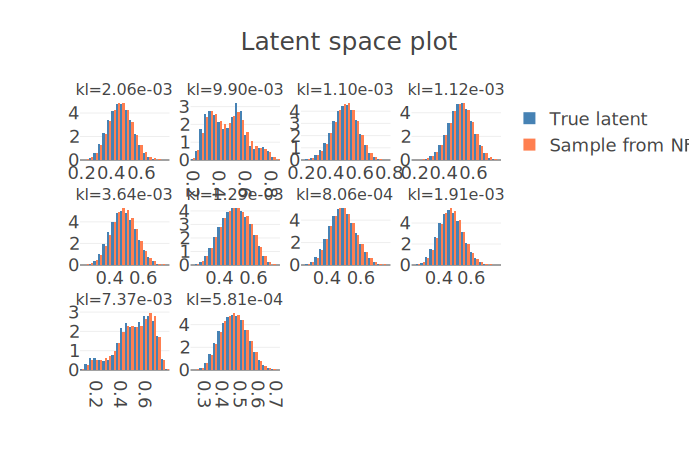

In [14]:
z_true = pae.ae.encode(dataset['x_train'])
z_sample = pae.nf.sample(dataset['x_train'].shape[0])

from plotting import latent_space_plot

fig = latent_space_plot(z_true, z_sample)
fig.show('svg')

### Normalizing flows

In [15]:
cnf = CondMAF(**nf_config)


In [16]:
cnf_optimizer =tfk.optimizers.Adam(lr=0.005)
cnf.compile(optimizer=cnf_optimizer, loss=lambda _, log_p: -log_p)


### Training

In [17]:
# ae_history = ae.fit(
#     x=dataset['x_train'],
#     y=dataset['x_train'],
#     batch_size=200,
#     epochs=180,
#     sample_weight=w_kde,
#     validation_data=(dataset["x_valid"],dataset["x_valid"],w_kde_valid),
#     callbacks=tfk.callbacks.ReduceLROnPlateau(
#         factor=0.2,
#         patience=10,
#         verbose=1
#     )
# )

In [18]:
z_train = ae.encode(dataset['x_train'])
z_valid = ae.encode(dataset['x_valid'])

In [19]:
cnf_history = cnf.fit(x=[z_train, c_train],
        y=np.zeros((160000,0)),
        batch_size=200,
        epochs=100,
        validation_data= ([z_valid, c_valid] ,np.zeros(z_valid.shape[0])),
        callbacks=tfk.callbacks.ReduceLROnPlateau(
        factor=0.2,
        patience=5,
        verbose=1))

# nf_history = nf.fit(x=z_train,
#         y=np.zeros((160000,0)),
#         batch_size=200,
#         epochs=100,
#         validation_data= (z_valid ,np.zeros(z_valid.shape[0])),
#         callbacks=tfk.callbacks.ReduceLROnPlateau(
#         factor=0.2,
#         patience=5,
#         verbose=1))

Epoch 1/100
800/800 [==============================] - 6s 5ms/step - loss: -9.7342 - val_loss: -11.2815
Epoch 2/100
800/800 [==============================] - 3s 4ms/step - loss: -11.9673 - val_loss: -12.6471
Epoch 3/100
800/800 [==============================] - 4s 5ms/step - loss: -12.6016 - val_loss: -12.6656
Epoch 4/100
800/800 [==============================] - 3s 4ms/step - loss: -12.9421 - val_loss: -13.1774
Epoch 5/100
800/800 [==============================] - 3s 4ms/step - loss: -13.0544 - val_loss: -13.1267
Epoch 6/100
800/800 [==============================] - 3s 4ms/step - loss: -13.1970 - val_loss: -13.3899
Epoch 7/100
800/800 [==============================] - 3s 4ms/step - loss: -13.3388 - val_loss: -12.7742
Epoch 8/100
800/800 [==============================] - 3s 4ms/step - loss: -13.3869 - val_loss: -13.5627
Epoch 9/100
800/800 [==============================] - 3s 4ms/step - loss: -13.4506 - val_loss: -13.4571
Epoch 10/100
800/800 [==============================] - 

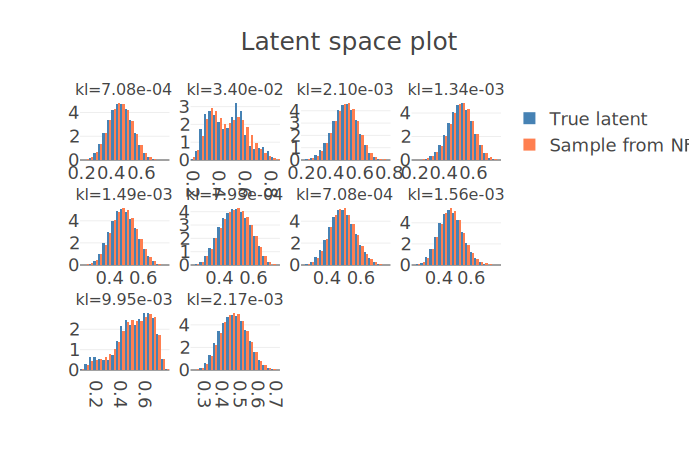

In [20]:
from plotting import latent_space_plot


cz_sample = cnf.sample(c_train, (c_train.shape[0],))

fig = latent_space_plot(z_train, cz_sample)
fig.show('svg')

### Scores

In [21]:
pmjj_train = fftkde.evaluate(dataset['mjj_train'])
pmjj = fftkde.evaluate(dataset['mjj_test'])

In [22]:
pmjj[pmjj<=0] = 1e-8
pmjj_train[pmjj_train<=0] = 1e-8

In [23]:
z_test = ae.encode(dataset['x_test'])

pz = nf(z_test).numpy()
cpz = cnf([z_test, c_test]).numpy()
pzr = pz-np.log(pmjj)
cpzr = cpz-np.log(pmjj)

pz_train = -nf(z_train).numpy()
cpz_train = -cnf([z_train, c_train]).numpy()
pzr_train = pz_train-np.log(pmjj_train)
cpzr_train = cpz_train-np.log(pmjj_train)


x_true = dataset['x_valid']
x_reco = ae(x_true)
sigma = np.mean(np.square(x_true-x_reco), axis=0)

### train_data
x_true = dataset['x_train']
x_reco = ae(x_true)
mse_train = np.mean(np.square(x_true-x_reco), axis=1)
nmse_train = np.dot(np.square(x_true-x_reco),sigma**(-1))

reco_error = np.square(x_true-x_reco)
z = z_train
byz = nf.inverse(z)
detJ = nf.inverse_log_det_jacobian(z)
apae_train = -0.5*np.dot(reco_error,sigma**(-1)) - \
        0.5*np.linalg.norm(byz,axis=1)**2 + detJ

byz = cnf.inverse([z, c_train])
detJ = cnf.inverse_log_det_jacobian([z, c_train])
cpae_train = -0.5*np.dot(reco_error,sigma**(-1)) - \
        0.5*np.linalg.norm(byz,axis=1)**2 + detJ

### test data
x_true = dataset['x_test']
x_reco = ae(x_true)
mse = np.mean(np.square(x_true-x_reco), axis=1)
nmse = np.dot(np.square(x_true-x_reco),sigma**(-1))

reco_error = np.square(x_true-x_reco)
z = z_test
byz = nf.inverse(z)
detJ = nf.inverse_log_det_jacobian(z)
apae = -0.5*np.dot(reco_error,sigma**(-1)) - \
        0.5*np.linalg.norm(byz,axis=1)**2 + detJ

byz = cnf.inverse([z, c_test])
detJ = cnf.inverse_log_det_jacobian([z, c_test])
cpae = -0.5*np.dot(reco_error,sigma**(-1)) - \
        0.5*np.linalg.norm(byz,axis=1)**2 + detJ

In [24]:
(pz_train-pz_train.min()).max()

52.443665

In [25]:
pz0 =np.exp(pz)/np.exp(pz).max()
cpz0 = np.exp(cpz)/np.exp(cpz).max()
pz_train0 =(pz_train-pz_train.min())/(pz_train-pz_train.min()).max()
cpz_train0 = (cpz_train-cpz_train.min())/(cpz_train-cpz_train.min()).max()
synergy = np.sqrt(pz0*(nmse/nmse.max()))
synergy_train = np.sqrt(pz_train0*(nmse_train/nmse_train.max()))
csynergy = np.sqrt(cpz0*(nmse/nmse.max()))
csynergy_train = np.sqrt(cpz_train0*(nmse_train/nmse_train.max()))

scores_train = {
    'pz': -pz_train,
    'cpz': -cpz_train,
    'mse': mse_train,
    'nmse': nmse_train,
    'pae': -apae_train,
    'cpae': -cpae_train,
    'pzr': -pzr_train,
    'cpzr': -cpzr_train,
    'synergy': -synergy_train,
    'csynergy': -csynergy_train
    }

scores_test = {
    'pz': -pz,
    'cpz': -cpz,
    'mse': mse,
    'nmse': nmse,
    'pae': -apae,
    'cpae': -cpae,
    'pzr': -pzr,
    'cpzr': -cpzr,
    'synergy': -synergy,
    'csynergy': -csynergy
    }

In [26]:
from scipy.spatial.distance import jensenshannon

def get_JSdiv(scores, mjj):
    prcs = np.arange(1,99)
    jsdivs = {'prc': prcs}
    n_full, b = np.histogram(mjj, bins=60, density=True)
    for key, score in scores.items():
        jsdivs[key] = []
        for prc in prcs:
            x_prc = np.percentile(score, prc)
            i_prc = np.where(score >= x_prc)[0]
            n_prc, _ = np.histogram(mjj[i_prc], bins=b, density=True)
            jsdivs[key].append(jensenshannon(n_full,n_prc))
    return jsdivs

In [27]:
jsdivs = get_JSdiv(scores_train, dataset['mjj_train'])

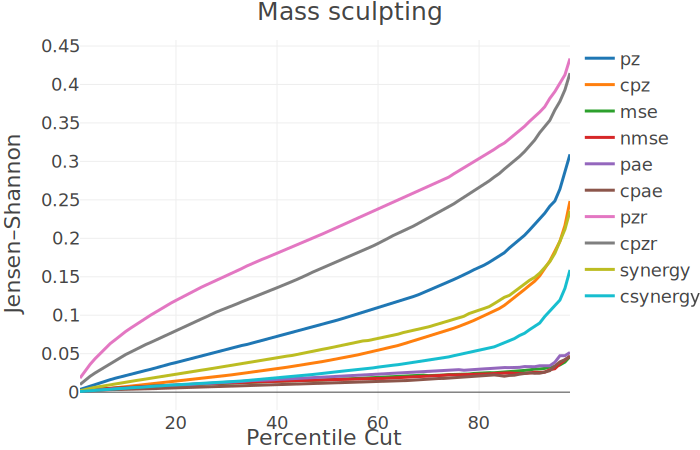

In [28]:

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "presentation"
from plotly.subplots import make_subplots

# mjj = dataset['mjj_train']
# max_prc = 99
# score = ascore_train
# n_full, b = np.histogram(mjj, bins=60, density=True)
# js_div = {}
# for prc in range(1, max_prc+1):
#     x_prc = np.percentile(ascore_train, prc)
#     i_prc = np.where(ascore_train >= x_prc)[0]
#     n_prc, _ = np.histogram(mjj[i_prc], bins=b, density=True)
#     js_div[prc] = jensenshannon(n_full,n_prc)

# cjs_div = {}
# for prc in range(1, max_prc+1):
#     x_prc = np.percentile(cascore_train, prc)
#     i_prc = np.where(cascore_train >= x_prc)[0]
#     n_prc, _ = np.histogram(mjj[i_prc], bins=b, density=True)
#     cjs_div[prc] = jensenshannon(n_full,n_prc)

fig = go.Figure()

for key in jsdivs.keys():
    if key is not 'prc':
        fig.add_trace(
    go.Scatter(x=jsdivs['prc'].tolist(), y=jsdivs[key], mode='lines',
        name=key)
    )

# fig.add_trace(
#     go.Scatter(x=list(js_div.keys()), y=list(js_div.values()), mode='lines',
#         name="MAF", line=dict(color="plum", width=3))
# )
# fig.add_trace(
#     go.Scatter(x=list(cjs_div.keys()), y=list(cjs_div.values()), mode='lines',
#         name="CondMAF", line=dict(color="tomato", width=3))
# )


fig.update_layout(
    title_text = "Mass sculpting",
    xaxis_title = "Percentile Cut",
    yaxis_title = "Jensen–Shannon",
    margin={'l': 80, 'b': 40, 't': 40, 'r': 0},
    width=750, height=450

)
fig.show('svg')
fig.write_image("cond-JS.png")

pz
cpz
mse
nmse
pae
cpae
pzr
cpzr
synergy
csynergy


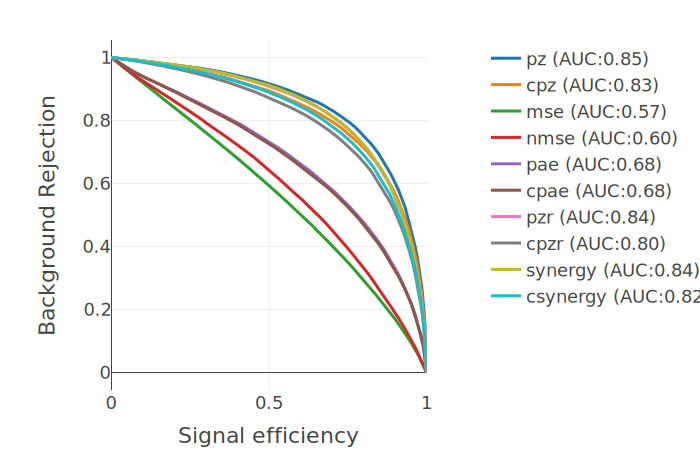

In [29]:
from sklearn.metrics import roc_curve, auc
import plotly.express as px

def binarize(label):
    return 1 if label == 'sig' else 0
labels = np.array(list(map(binarize, dataset['labels'])))


# fpr, tpr, thresholds = roc_curve(labels, ascore)
# nf_auc = auc(1-fpr, tpr)

# cfpr, ctpr, thresholds = roc_curve(labels, cascore)
# cnf_auc = auc(1-cfpr, ctpr)

fig = go.Figure()

for key,score in scores_test.items():
    print(key)
    fpr, tpr, thresholds = roc_curve(labels, score)
    vauc = auc(1-fpr, tpr)    
    fig.add_trace(
    go.Scatter(x=tpr, y=1-fpr, mode='lines',
        name=f"{key} (AUC:{vauc:.2f})",)
        )
# fig.add_trace(
#     go.Scatter(x=tpr, y=1-fpr, mode='lines',
#         name=f"NF (AUC:{nf_auc:.2f})", line=dict(color="Plum", width=2))
# )

# fig.add_trace(
#     go.Scatter(x=ctpr, y=1-cfpr, mode='lines',
#         name=f"cNF (AUC:{cnf_auc:.2f})", line=dict(color="Tomato", width=2))
# )

fig.update_layout(
    width=800, height=500,
    xaxis_title = "Signal efficiency",
    yaxis_title = "Background Rejection",
    margin={'l': 60, 'b': 60, 't': 40, 'r': 0},
    showlegend = True
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.write_image("cflows.png")
fig.show('svg')


In [30]:
(np.exp(pz)/np.exp(pz).max()).max()

1.0

# MISC

In [31]:
# test_fractions = {
#     'bkg':200_000,
#     'sig':400
# }
# test2 = loader.make_test(test_fractions, replace=False)


# z_test2 = ae.encode(test2['x_test'])
# c_test2 = scaler.transform(test2['mjj_test'].reshape(-1,1))

# cpz = cnf([z_test2, c_test2]).numpy()

In [32]:
# import plotly.graph_objects as go
# import plotly.express as px
# import plotly.io as pio
# pio.templates.default = "presentation"
# from plotly.subplots import make_subplots

# prc=95

# ascore = -cpz

# x_min = np.percentile(ascore, 1)
# x_max = np.percentile(ascore, 99)
# x_prc = np.percentile(ascore, prc)
# i_prc = (ascore >= x_prc)

# fig = go.Figure()
# fig.add_trace(go.Histogram(x=ascore, name='Test dataset', 
#                            marker_color='plum', nbinsx=400),
#              )
# fig.add_vline(x=x_prc, y1=5100, line_width=2, line_color='firebrick', 
#               annotation_text=f"{prc}th percentile", 
#               annotation_position="top right",
#               )

# fig.update_layout(
#     xaxis_title='Anomaly Score',
#     #title_text=r'Cut on Anomaly Score',
#     width=600)
# fig.show('svg')

# ##################################################3
# mjj=test2['mjj_test']
# def binarize(label):
#     return 1 if label == 'sig' else 0
# labels = np.array(list(map(binarize, test2['labels'])))
# sig_label = (labels==1)
# bkg_label = (labels==0)

# fig = go.Figure()
# fig.add_trace(go.Histogram(x=mjj[bkg_label], name="Full test bkg",
#                           marker_color='steelblue'))
# fig.add_trace(go.Histogram(x=mjj[sig_label], name="Full test sig",
#                           marker_color='darkorange'))
# sb = 100*sum(sig_label)/sum(bkg_label)
# fig.update_layout(
#     xaxis_title='$$m_{jj}$$',
#     title_text=f'Dijet mass spectrum of test dataset S/B={sb:.2f}%',
#     width=600,
#     barmode='stack'
#     )
# fig.show('svg')        
# #################################################3     
# fig = go.Figure()
# fig.add_trace(go.Histogram(x=mjj[i_prc&bkg_label], name="Full test bkg",
#                           marker_color='steelblue', nbinsx=100))
# fig.add_trace(go.Histogram(x=mjj[i_prc&sig_label], name="Full test sig",
#                           marker_color='darkorange'))
# sb = 100*sum(i_prc&sig_label)/sum(i_prc&bkg_label)
# fig.update_layout(
#     xaxis_title='$$m_{jj}$$',
#     title_text=f'Dijet mass spectrum of test dataset after cut S/B={sb:.2f}%',
#     width=600,
#     barmode='stack'
#     )
# fig.show('svg')   